#<b>Neural Cryptography</b>

###<b>Import Libraries

In [1]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
tf.reset_default_graph()
import numpy as np
import matplotlib.pyplot as plt

###<b>Configurable Parameters

In [2]:
# Input configuration.
text_size = 16
key_size  = 16

# Training parameters.
learning_rate   = 0.0008
batch_size      = 4096
sample_size     = 4096*5
epochs          = 8000
steps_per_epoch = int(sample_size/batch_size)

ITERS_PER_ACTOR = 1
EVE_MULTIPLIER = 2  # Train Eve 2x for every step of Alice/Bob

In [3]:
#Variables for graphs
values_of_i=[]
alice_bob_acc=[]
eve_acc=[]

###<b>Random Dataset</b>

In [5]:
def random_bools(size, n):

  # create a batch size of 'size' with 'n' number of bits per sample
  temp =  np.random.random_integers(0, high=1, size=[size, n])

  # Convert 0 -> -1 and 1 -> 1 
  temp = temp*2 - 1

  return temp.astype(np.float32)

def get_dataset(sample_size, text_size, key_size):

  m = random_bools(sample_size, text_size)
  k = random_bools(sample_size, key_size)

  return m, k

###<b>Creating Models

In [6]:
# Function to return a list of tensor's to be used in training based on the scope of model
def get_collection(collection):
  return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=collection) 

# Create two placeholders to hold message and key
input_message = tf.placeholder(tf.float32, shape=(batch_size, text_size), name='input_message')
input_key     = tf.placeholder(tf.float32, shape=(batch_size, key_size), name='input_key')


# Function to create individual models for Alice, Bob and Eve.
def model(collection, message, key=None):

  if key is not None:
    # if there is a key then it's either Alice or Bob model trying to encrypt and decrypt resp
    # message and key is concatenated into single tensor and fed as an input
    combined_input = tf.concat(axis=1, values=[message, key])
  else:
    # if no key is present then it's Eve model trying to eavesdrop hence pass the message as input tensor 
    combined_input = message

  # collection arg is to denote the scope of model which is used to aggregate the 
  # tensor to make sure all tensor which needs to be trained are inside one scope
  with tf.variable_scope(collection):


    ## Fully connected layer of 16+16 = 32 neurons
    fc = tf.layers.dense(combined_input, text_size + key_size, activation=tf.nn.relu)
    # expand and create channel to be valid for convolution
    # i.e convert FC layer a vector of 32 to matrix of (32,1) 
    fc = tf.expand_dims(fc, 2)


    ## Convolution Layers - Sigmoid activation function

    # input: (32,1) -> output:(32,2) because filter is 2 which creates 2 channels
    conv1 = tf.layers.conv1d( fc,    filters=2, kernel_size=4, strides= 1, padding='SAME',  activation=tf.nn.sigmoid)

    # input: (32,2) -> output:(16,4) because stride is 2 hence result is halved ( i.e 32/2 )
    # filter is 4 which creates 4 channels
    conv2 = tf.layers.conv1d( conv1, filters=4, kernel_size=2, strides= 2, padding='VALID', activation=tf.nn.sigmoid)

    # input: (16,4) -> output:(16,4) because filter is 4 which creates 4 channels
    conv3 = tf.layers.conv1d( conv2, filters=4, kernel_size=1, strides= 1, padding='SAME',  activation=tf.nn.sigmoid)


    ## Convolution Layers - Tanh activation function

    # input: (16,4) -> output:(16,1) because filter is 1 which creates 1 channel
    conv4 = tf.layers.conv1d( conv3, filters=1, kernel_size=1, strides=1, padding='SAME', activation=tf.nn.tanh)

    # Opposite of expand_dims function, here (16,1) tensor is converted to tensor of (16)
    conv4 = tf.squeeze(conv4, 2)


    return conv4

###<b>Loss Functions

In [7]:
def eve_loss(input_message, eve_out_message, batch_size):

  # Mapping -1 to 0 and 1 to 1
  eve_diff = (eve_out_message + 1.0)/2.0 - (input_message + 1.0)/2.0

  # Eve's average L1 distance Loss of the given batch
  loss = (1/batch_size)*tf.reduce_sum(tf.abs(eve_diff))

  return loss

def alice_bob_loss(input_message, bob_out_message, Eve_loss, batch_size):

  ## Alice-Bob Loss part-1

  # Mapping -1 to 0 and 1 to 1
  ab_diff = (bob_out_message + 1.0)/2.0 - (input_message + 1.0)/2.0

  # Alice and Bob's average L1 distance Loss of the given batch
  bob_reconstruction_loss = (1/batch_size)*tf.reduce_sum(tf.abs(ab_diff))

  ## Alice-Bob Loss part-2
  # To make sure Eve at least has 50% of bits wrong so that output simulates random probability of binary output
  # ((N/2 - EveLoss)^2)/((N/2)^2)
  eve_evedropping_loss = tf.reduce_sum( tf.square(float(text_size) / 2.0 - Eve_loss) / (text_size / 2)**2)

  # bobs final reconstruction loss
  loss = bob_reconstruction_loss + eve_evedropping_loss

  return loss

###<b>Symmetric Key Cryptosystem

In [4]:
def symm_crypto_create(input_message, input_key):

  # Alice takes in message and shared secret key to encrypt and create a ciphertext
  Alice_out_ciphertext = model( 'Alice', input_message, input_key)

  # Bob takes in ciphertext and shared secret key to decrypt and recreate the original message
  Bob_out_message      = model( 'Bob',   Alice_out_ciphertext, input_key)

  # Eve only takes in ciphertext and tries to decrypt it without using key
  Eve_out_message      = model( 'Eve',   Alice_out_ciphertext)

  return Bob_out_message, Eve_out_message


###<b>Training

In [8]:
sess = tf.Session()

# Create symmetric cryptosystem in form of adversarial networks
Bob_out, Eve_out = symm_crypto_create(input_message, input_key)

# Loss
eve_loss       = eve_loss(input_message, Eve_out, batch_size)
alice_bob_loss = alice_bob_loss(input_message, Bob_out, eve_loss, batch_size)

# Collect each model's tensors
alice_vars = get_collection('Alice')
bob_vars   = get_collection('Bob')
eve_vars   = get_collection('Eve')

# optimizers
Eve_opt  = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, epsilon=1e-08).minimize(eve_loss, var_list=[eve_vars])
bob_opt  = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, epsilon=1e-08).minimize(alice_bob_loss, var_list=[alice_vars + bob_vars]) 

# initialize variables
init = tf.global_variables_initializer()
sess.run(init)


# DATASET 
messages, keys = get_dataset(sample_size, text_size, key_size)

for i in range(epochs):

  for j in range(steps_per_epoch):
    
    # select the batch from the samples
    batch_messages = messages[j*batch_size: (j+1)*batch_size]
    batch_keys     = keys[j*batch_size: (j+1)*batch_size]

    # Train Alice and Bob's models
    for _ in range(ITERS_PER_ACTOR):
      temp = sess.run([bob_opt, alice_bob_loss],feed_dict={input_message:batch_messages , input_key:batch_keys })
      Alice_bob_loss = temp[1]

    # Train Eve's model
    for _ in range(ITERS_PER_ACTOR*EVE_MULTIPLIER):
      temp = sess.run([Eve_opt, eve_loss], feed_dict={input_message:batch_messages , input_key:batch_keys })
      Eve_loss = temp[1]

  # output Alice-Bob loss and Eve's loss after every 100 iterations  
  if i%100 == 0:
    print(i,'  Alice_bob_loss: ', Alice_bob_loss,'    Eve_loss:', Eve_loss)
    values_of_i.append(i)
    alice_bob_acc.append((8-Alice_bob_loss)*1.25)
    eve_acc.append((8-Eve_loss)*1.25)
sess.close()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:202: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  warnings.warn('`tf.layers.conv1d` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  after rem

0   Alice_bob_loss:  7.999582     Eve_loss: 7.9872055
100   Alice_bob_loss:  5.229217     Eve_loss: 3.4507287
200   Alice_bob_loss:  1.2047093     Eve_loss: 2.6849322
300   Alice_bob_loss:  0.606116     Eve_loss: 4.719716
400   Alice_bob_loss:  0.41270494     Eve_loss: 5.8589387
500   Alice_bob_loss:  0.3497555     Eve_loss: 6.261297
600   Alice_bob_loss:  0.31275505     Eve_loss: 6.601489
700   Alice_bob_loss:  0.29174447     Eve_loss: 6.8337383
800   Alice_bob_loss:  0.27965957     Eve_loss: 6.9830604
900   Alice_bob_loss:  0.27154753     Eve_loss: 7.098042
1000   Alice_bob_loss:  0.26663885     Eve_loss: 7.162318
1100   Alice_bob_loss:  0.26136592     Eve_loss: 7.2753124
1200   Alice_bob_loss:  0.2582743     Eve_loss: 7.3441863
1300   Alice_bob_loss:  0.25636852     Eve_loss: 7.37733
1400   Alice_bob_loss:  0.25383887     Eve_loss: 7.4607935
1500   Alice_bob_loss:  0.25208274     Eve_loss: 7.5307617
1600   Alice_bob_loss:  0.26568294     Eve_loss: 7.0678844
1700   Alice_bob_loss:  0

###<b>Results

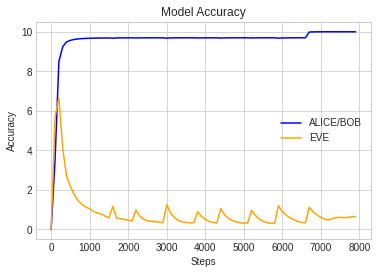

In [9]:
plt.style.use('seaborn-whitegrid')

plt.plot(values_of_i,alice_bob_acc, color='blue',label='ALICE/BOB')
plt.plot(values_of_i, eve_acc, color='orange',label='EVE')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()
